In [1]:
from transformers import DecisionTransformerModel
import torch
import numpy as np
import matplotlib.pyplot as plt  

model_name = r"D:\UCL_codes\research project\Untitled Folder\output\checkpoint-100000"
model = DecisionTransformerModel.from_pretrained(model_name)

state_dim = 1 # state size
act_dim = 1 # action size

D:\anaconda3\envs\research\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# environment data 
import os
import json
folder_path = r'.\Onefunction_PI'
save_path = 'train_data_strategy_1'
filename = '1.json'
with open(os.path.join(folder_path, filename), 'r') as f:
    data = json.load(f)
xs = data['xs']
ys = data['ys']
x_obs = data['PI']['x_obs']
y_obs = data['PI']['y_obs']
with open(os.path.join(save_path, filename), 'r') as f:
    data = json.load(f)
rtg = data['RTG']
print(x_obs[0],y_obs[0])
print(data['A'][0],data['S'][0],data['RTG'][0],)



3.735 -0.6250762041214045
3.735 0 24


In [3]:
def get_action(model, states, actions, rewards, returns_to_go, timesteps):
    # This implementation does not condition on past rewards

    states = states.reshape(1, -1, model.config.state_dim)
    actions = actions.reshape(1, -1, model.config.act_dim)
    returns_to_go = returns_to_go.reshape(1, -1, 1)
    timesteps = timesteps.reshape(1, -1)

    # The prediction is conditioned on up to 20 previous time-steps
    states = states[:, -model.config.max_length:]
    actions = actions[:, -model.config.max_length:]
    returns_to_go = returns_to_go[:, -model.config.max_length:]
    timesteps = timesteps[:, -model.config.max_length:]

    # pad all tokens to sequence length, this is required if we process batches
    padding = model.config.max_length - states.shape[1]
    attention_mask = torch.cat([torch.zeros(padding), torch.ones(states.shape[1])])
    attention_mask = attention_mask.to(dtype=torch.long).reshape(1, -1)
    states = torch.cat([torch.zeros((1, padding, state_dim)), states], dim=1).float()
    actions = torch.cat([torch.zeros((1, padding, act_dim)), actions], dim=1).float()
    returns_to_go = torch.cat([torch.zeros((1, padding, 1)), returns_to_go], dim=1).float()
    timesteps = torch.cat([torch.zeros((1, padding), dtype=torch.long), timesteps], dim=1)

    # perform the prediction
    state_preds, action_preds, return_preds = model(
        states=states,
        actions=actions,
        rewards=rewards,
        returns_to_go=returns_to_go,
        timesteps=timesteps,
        attention_mask=attention_mask,
        return_dict=False, )
    return action_preds[0, -1]

def find_nearest(array, x):
    min_diff = float('inf')
    min_index = None
    for i, a in enumerate(array):
        diff = abs(a - x)
        if diff < min_diff:
            min_diff = diff
            min_index = i
    return min_index

In [4]:
target_return = torch.tensor(4).float().reshape(1, 1)
states = torch.zeros((1, state_dim)).float()
actions = torch.zeros((0, act_dim)).float()
rewards = torch.zeros(0).float()
timesteps = torch.tensor(0).reshape(1, 1).long()
print(states.size(), actions.size(), rewards.size(), target_return.size())
states.shape[1]

torch.Size([1, 1]) torch.Size([0, 1]) torch.Size([0]) torch.Size([1, 1])


1

In [5]:
for t in range(30):    
    actions = torch.cat([actions, torch.zeros((1, act_dim))], dim=0)
    rewards = torch.cat([rewards, torch.zeros(1)])
    action = get_action(model,
                            states,
                            actions,
                            rewards,
                            target_return,
                            timesteps)
    print(action*5)
    action_index = find_nearest(xs,action*5)
    state = torch.tensor(ys[action_index]).view(1, 1)
    action = torch.tensor(xs[action_index]).view(1, 1)
    rtg = torch.tensor(int(target_return[0, -1])-1).float().reshape(1, 1)

    states = torch.cat([states, state], dim=0).float()
    actions[-1] = action
    rewards[-1] = torch.ones(1)
    target_return = torch.cat([target_return, rtg], dim=1).float()
    timesteps = torch.cat([timesteps, torch.ones((1, 1)).long() * (t + 1)], dim=1)
    print(states.size(), actions.size(),target_return.size(), rewards.size(), target_return.size())

tensor([0.0718], grad_fn=<MulBackward0>)
torch.Size([2, 1]) torch.Size([1, 1]) torch.Size([1, 2]) torch.Size([1]) torch.Size([1, 2])
tensor([-2.7848], grad_fn=<MulBackward0>)
torch.Size([3, 1]) torch.Size([2, 1]) torch.Size([1, 3]) torch.Size([2]) torch.Size([1, 3])
tensor([-3.6259], grad_fn=<MulBackward0>)
torch.Size([4, 1]) torch.Size([3, 1]) torch.Size([1, 4]) torch.Size([3]) torch.Size([1, 4])
tensor([4.9348], grad_fn=<MulBackward0>)
torch.Size([5, 1]) torch.Size([4, 1]) torch.Size([1, 5]) torch.Size([4]) torch.Size([1, 5])
tensor([4.9893], grad_fn=<MulBackward0>)
torch.Size([6, 1]) torch.Size([5, 1]) torch.Size([1, 6]) torch.Size([5]) torch.Size([1, 6])
tensor([4.9895], grad_fn=<MulBackward0>)
torch.Size([7, 1]) torch.Size([6, 1]) torch.Size([1, 7]) torch.Size([6]) torch.Size([1, 7])
tensor([4.9996], grad_fn=<MulBackward0>)
torch.Size([8, 1]) torch.Size([7, 1]) torch.Size([1, 8]) torch.Size([7]) torch.Size([1, 8])
tensor([4.9999], grad_fn=<MulBackward0>)
torch.Size([9, 1]) torch.S

[0.07000000029802322, 0.0, 0.0, 4.934999942779541, 4.989999771118164, 4.989999771118164, 5.0, 5.0, 4.985000133514404, 4.989999771118164, 0.0, 5.0, 4.929999828338623, 5.0, 4.954999923706055, 4.945000171661377, 5.0, 4.795000076293945, 4.795000076293945, 5.0, 5.0, 5.0, 5.0, 4.894999980926514, 5.0, 4.980000019073486, 4.074999809265137, 5.0, 4.75, 0.0]
31
max_value: 0.8560300469398499
max_index: 18


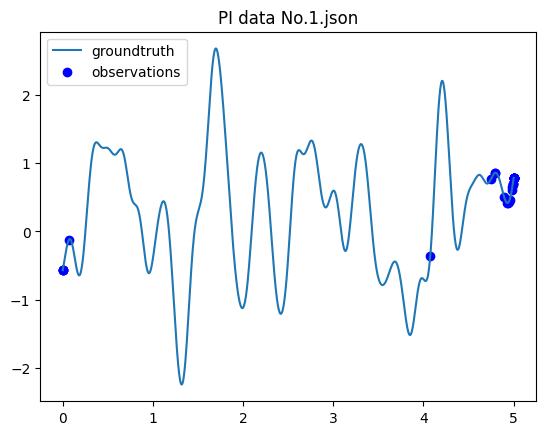

In [6]:
print(actions.reshape(-1).tolist())
print(len(states.reshape(-1).tolist()))
print("max_value:", torch.max(states).item())
print("max_index:", torch.argmax(states).item())
plt.plot(xs, ys, label = 'groundtruth')
plt.scatter(actions, states[1:], label = 'observations',c='b')
plt.legend()
plt.title( 'PI data No.'+str(filename) )
plt.show()

In [7]:
print(data['A'],data['S'])

[3.735, 0.0, 0.86, 0.96, 0.8200000000000001, 0.76, 0.66, 0.63, 1.32, 2.1750000000000003, 2.235, 2.07, 4.575, 4.675, 4.4350000000000005, 4.835, 4.945, 2.99, 2.865, 3.145, 2.695, 2.645, 2.54, 4.105, 1.695, 1.72, 1.6400000000000001, 3.435, 0.29, 3.94, 4.255, 0.41500000000000004, 3.575, 3.3000000000000003, 1.87, 0.155, 1.1300000000000001, 2.39, 4.32, 4.195, 1.49, 0.495, 3.835, 5.0, 3.235, 4.755, 1.205, 2.785, 1.965, 0.075, 3.6550000000000002, 0] [0, -0.6250762041214045, -0.5681424030680832, 0.1642534074841468, -0.6092041357060602, 0.3680109104289028, 0.4949049722078865, 1.1832205329391008, 1.1914882796809394, -2.2383187886964397, 1.0814212867534516, 1.0245921516336474, -0.4345148689017537, 0.7652276639764811, 0.7360187314858049, 0.10058988888118321, 0.7861115957725884, 0.4307974516011793, 0.5800560575903002, 0.5668338030505861, -0.26899053000129997, 1.1602292902251623, 1.154923932830813, 0.43020799552765826, 0.26206678582391096, 2.6730387989219673, 2.593288167724146, 2.1109965038009197, -0